In [2]:
#함수를 모아둔 것이 library, library를 모아둔 것이 framework이다.
#facebook이 만든 머신러닝 library가 pytorch이다. tensorflow는 google이 만든 library이다.
#from torchaudio.datasets import YESNO #torchaudio library내 dataset중 YSENO를 가져와라
# Step 1. 필요한 라이브러리 설치 및 임포트
!pip install torchaudio --quiet

import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchaudio.datasets import YESNO
from torch.nn.utils.rnn import pad_sequence

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.4 MB/s eta 0:00:00


In [4]:
# Step 2. 데이터셋 로드
dataset = YESNO(root="./data", download=True)

# 하나 확인
waveform, sample_rate, label = dataset[0]
print(f"Waveform shape: {waveform.shape}")
print(f"Sample rate: {sample_rate}")
print(f"Label (yes=1, no=0): {label}")

FileNotFoundError: [Errno 2] No such file or directory: 'data/waves_yesno.tar.gz.9eefdd3a4fc04596891b2952961ebc50.partial'

In [ ]:
# Step 3. Mel Spectrogram 변환기 정의 및 시각화
mel_transform = T.MelSpectrogram(sample_rate=sample_rate, n_mels=64)

mel_spec = mel_transform(waveform)

plt.figure(figsize=(10, 4))
plt.imshow(mel_spec[0].log2().detach().numpy(), origin='lower', aspect='auto')
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.colorbar()
plt.show()

In [ ]:
# Step 4. 전처리된 데이터셋 클래스 정의
class MelDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = mel_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sr, label = self.dataset[idx]
        mel = self.transform(waveform).squeeze(0).T  # [Time, Mel]
        return mel, torch.tensor(sum(label) % 10)  # 0~9 라벨 생성 (단순 분류용)

def collate_fn(batch):
    mels, labels = zip(*batch)
    mels_padded = pad_sequence(mels, batch_first=True).permute(0, 2, 1)  # [B, M, T]
    mels_padded = mels_padded.unsqueeze(1)  # [B, 1, M, T]
    return mels_padded, torch.tensor(labels)

In [ ]:
# Step 5. DataLoader 생성
train_loader = DataLoader(MelDataset(dataset), batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
#step 6 CNN으로 학습
class CNNAudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential( #신경망 설계
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # [B, 1, 64, T] → [B, 16, 64, T]
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                        # [B, 16, 32, T//2]
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                        # [B, 32, 16, T//4]
            nn.AdaptiveAvgPool2d((4, 4))                 # ★ 여기서 [B, 32, 4, 4]로 고정
        )
        self.fc = nn.Sequential(
            nn.Flatten(),                               # [B, 32*4*4] = [B, 512]
            nn.Linear(32 * 4 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [ ]:
# Step 7. 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNAudioClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
#학습을 할 때 weight값이 학습되는 방향내에서 random값으로 갱신되는데 이때 학습을 할 때마다 weight값이 다르게 나오고
#전에 했던 것보다 loss가 더 나올 수 있다. 그래서 학습을 많이 시키는 이유도 random하게 나오는 weight를 더 정확하게 하기 위함이다.
for epoch in range(50):
    total_loss = 0
    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

In [ ]:
# 여러 개 샘플 추론
model.eval()
for idx in range(5):
    waveform, sr, label = dataset[idx]
    mel = mel_transform(waveform).squeeze(0).T.unsqueeze(0).permute(0, 2, 1).unsqueeze(1).to(device)
    with torch.no_grad():
        pred = model(mel).argmax(dim=1).item()
    print(f"[샘플 {idx}] 실제: {sum(label)} → 예측: {pred}")

In [ ]:
!pip install torchaudio --quiet

데이터셋 로딩 (train-clean-100의 앞 200개 샘플 사용)

In [ ]:
import torch
import torchaudio
from torchaudio.datasets import LIBRISPEECH
from torch.utils.data import Subset

full_dataset = LIBRISPEECH(root="./", url="train-clean-100", download=True)
train_dataset = Subset(full_dataset, range(200))

문자 사전 및 텍스트 인코딩 함수 정의

In [ ]:
vocab = list("abcdefghijklmnopqrstuvwxyz '")
vocab_dict = {c: i for i, c in enumerate(vocab)}
inv_vocab_dict = {i: c for c, i in vocab_dict.items()}

def text_to_indices(text):
    return [vocab_dict[c] for c in text.lower() if c in vocab_dict]

def indices_to_text(indices):
    return ''.join([inv_vocab_dict[i] for i in indices if i in inv_vocab_dict])

MelSpectrogram 변환 및 DataLoader용 Collate 함수 정의

In [ ]:
import torchaudio.transforms as T
from torch.nn.utils.rnn import pad_sequence

mel_transform = T.MelSpectrogram(sample_rate=16000, n_mels=64)

def collate_fn(batch):
    specs, labels, input_lens, label_lens = [], [], [], []

    for waveform, sr, text, *_ in batch:
        mel = mel_transform(waveform).squeeze(0).transpose(0, 1)
        label = torch.tensor(text_to_indices(text), dtype=torch.long)
        specs.append(mel)
        labels.append(label)
        input_lens.append(mel.shape[0])
        label_lens.append(len(label))

    specs_padded = pad_sequence(specs, batch_first=True).transpose(1, 2)
    labels_padded = pad_sequence(labels, batch_first=True)

    return specs_padded, labels_padded, torch.tensor(input_lens), torch.tensor(label_lens)

CNN 기반 CTC 모델 정의

In [ ]:
import torch.nn as nn

class CNNCTCModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, vocab_size, kernel_size=1)
        )

    def forward(self, x):  # x: [B, Mels, T]
        x = self.cnn(x)
        return x.permute(2, 0, 1)  # [T, B, Vocab]

학습 준비 및 실행

In [ ]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNCTCModel(vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ctc_loss = nn.CTCLoss(blank=vocab_dict[' '], zero_infinity=True)

dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

for epoch in range(100):
    model.train()
    total_loss = 0
    for mel, label, input_lens, label_lens in dataloader:
        mel, label = mel.to(device), label.to(device)
        output = model(mel)
        log_probs = torch.nn.functional.log_softmax(output, dim=2)
        loss = ctc_loss(log_probs, label, input_lens, label_lens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1} - Loss: {total_loss:.4f}")

Greedy 디코딩 함수

In [ ]:
def greedy_decode(output, blank=vocab_dict[' ']):
    pred = torch.argmax(output, dim=-1)
    results = []
    for p in pred:
        tokens = []
        prev = blank
        for idx in p:
            idx = idx.item()
            if idx != prev and idx != blank:
                tokens.append(idx)
            prev = idx
        results.append(tokens)
    return results

샘플 추론

In [ ]:
model.eval()
with torch.no_grad():
    waveform, sr, text, *_ = train_dataset[10]
    mel = mel_transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
    output = model(mel)  # [T, B, V]
    decoded = greedy_decode(output.softmax(2).transpose(0, 1))[0]
    predicted_text = indices_to_text(decoded)

print("정답 문장:", text.lower())
print("예측 결과:", predicted_text)

In [ ]:
!pip install torchaudio --quiet

Matplotlib 한글화

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib  # 한글 폰트 적용

2. 예제용 음성 데이터 로드

In [ ]:
import torchaudio
import matplotlib.pyplot as plt
import torch

# 샘플 음성: yesno 데이터셋에서 하나 가져오기
from torchaudio.datasets import YESNO

dataset = YESNO(root="./", download=True)
waveform, sample_rate, label = dataset[0]

print("원본 waveform shape:", waveform.shape)

3. 시각화 함수

In [ ]:
def plot_wave(waveform, title):
    plt.figure(figsize=(10, 2))
    plt.title(title)
    plt.plot(waveform.t().numpy())
    plt.show()

4. 데이터 증강 예제

데이터 증강을 하는 이유는 과적합을 피하고 일반화 성능 향상을 위함이다.

(1) 노이즈 추가

In [ ]:
def add_noise(waveform, noise_level=0.005):
    noise = torch.randn(waveform.size()) * noise_level
    return waveform + noise

noisy = add_noise(waveform)
plot_wave(noisy, "노이즈 추가")

(2) 속도 변화 (속도 줄이기)

빠르게 말하는 경우
느리게 말하는 경우의 입력 데이터가 왔을 경우에도 예측이 제대로 되도록 하기위함

In [ ]:
from torchaudio.functional import resample

def change_speed(waveform, orig_sr, new_sr):
    return resample(waveform, orig_freq=orig_sr, new_freq=new_sr)

slower = change_speed(waveform, sample_rate, int(sample_rate * 0.8)) #느리게 하기 위해서는 1.2이나 1.4를 넣으면 된다.
plot_wave(slower, "속도 빠르게 (0.8x)")

(3) 피치 조절(음정 조절)

In [ ]:
import torchaudio.transforms as T

def change_pitch(waveform, sample_rate, n_steps):
    effect = [['pitch', str(n_steps * 100)], ['rate', str(sample_rate)]]
    return torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effect)[0]

higher_pitch = change_pitch(waveform, sample_rate, n_steps=3)
plot_wave(higher_pitch, "피치 높이기 (+3)")

(4) 시간 스트레칭 (Time Stretching)

※ TimeStretch는 복소수 입력을 필요로 하므로 실제 오디오 재생용으로는 Griffin-Lim 역변환이 필요합니다.

In [ ]:
spectrogram = T.Spectrogram()(waveform)
stretch = T.TimeStretch()
stretched = stretch(spectrogram, 0.8)
# 역변환 필요 시 Griffin-Lim 사용

원본 소리에 노이즈 추가하는 코드 예시 시작

100%|██████████| 331M/331M [00:26<00:00, 13.1MB/s]


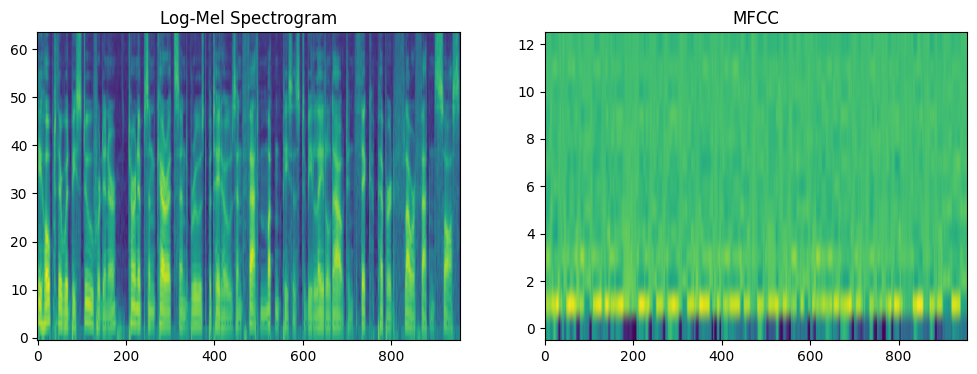

In [1]:
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# 1) 데이터 로드
waveform, sr, transcript, *_ = torchaudio.datasets.LIBRISPEECH(
    root="./", url="test-clean", download=True
)[0]

# 2) 16 kHz 리샘플링
if sr != 16000:
    waveform = T.Resample(sr, 16000)(waveform)
    sr = 16000

# 3) 진폭 정규화
waveform = waveform / waveform.abs().max()

# 4) 무음 제거 (RMS 기반)
frame_len = int(sr * 0.02)                       # 20 ms 프레임
energy = waveform.unfold(1, frame_len, frame_len).pow(2).mean(dim=2)
mask = (energy > 1e-4).to(torch.int64)           # Bool → int64 변환

if mask.sum() == 0:                              # 전부 무음인 경우
    start, end = 0, waveform.size(1)
else:
    start = int(mask.argmax()) * frame_len
    end = int(len(mask) - mask.flip(1).argmax()) * frame_len

waveform = waveform[:, start:end]

# 5) 특징 추출
mel_spec = T.MelSpectrogram(sample_rate=sr,
                            n_fft=400,
                            hop_length=160,
                            n_mels=64)(waveform)

mfcc = T.MFCC(sample_rate=sr,
              n_mfcc=13,
              melkwargs={'n_fft': 400,
                         'hop_length': 160,
                         'n_mels': 64})(waveform)

# 6) 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mel_spec.log2()[0].numpy(), origin="lower", aspect="auto")
plt.title("Log-Mel Spectrogram")
plt.subplot(1, 2, 2)
plt.imshow(mfcc[0].numpy(), origin="lower", aspect="auto")
plt.title("MFCC")
plt.show()

마이크입력에 의한 음성녹음과 SNR 5dB, 10dB, 15dB로 음성에 노이즈를 추가

In [4]:
!pip install -q soundfile

from google.colab import output
from base64 import b64decode
from IPython.display import Audio, display
import io
import soundfile as sf

RECORD_SEC = 3

# JavaScript 코드: 마이크 녹음 및 base64 반환
record_js = f"""
async function recordAudio() {{
  const sleep = time => new Promise(resolve => setTimeout(resolve, time));
  const b2text = blob => new Promise(resolve => {{
    const reader = new FileReader();
    reader.onloadend = () => resolve(reader.result);
    reader.readAsDataURL(blob);
  }});

  let stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
  let recorder = new MediaRecorder(stream);
  let data = [];

  recorder.ondataavailable = event => data.push(event.data);
  recorder.start();

  await sleep({RECORD_SEC * 1000});
  recorder.stop();

  await new Promise(resolve => recorder.onstop = resolve);
  let blob = new Blob(data);
  return await b2text(blob);
}}
recordAudio();
"""

print(f"▶ 마이크 녹음을 {RECORD_SEC}초 동안 시작합니다...")
audio_base64 = output.eval_js(record_js)

# base64 디코딩 및 저장
audio_bytes = b64decode(audio_base64.split(',')[1])
with open("recorded.wav", "wb") as f:
    f.write(audio_bytes)

display(Audio("recorded.wav"))

▶ 마이크 녹음을 3초 동안 시작합니다...


In [5]:
# STEP 1: 설치 (최초 1회만 실행)
!apt-get install -y ffmpeg
!pip install pydub

# STEP 2: 변환 (WebM/Opus → WAV)
from pydub import AudioSegment

# WebM 형식으로 저장된 파일을 WAV로 변환
input_path = "recorded.wav"         # 실질적으로 WebM 또는 Opus
converted_path = "converted.wav"    # WAV 파일로 저장

audio = AudioSegment.from_file(input_path)
audio = audio.set_frame_rate(16000).set_channels(1)
audio.export(converted_path, format="wav")

print("변환 완료: converted.wav")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
변환 완료: converted.wav


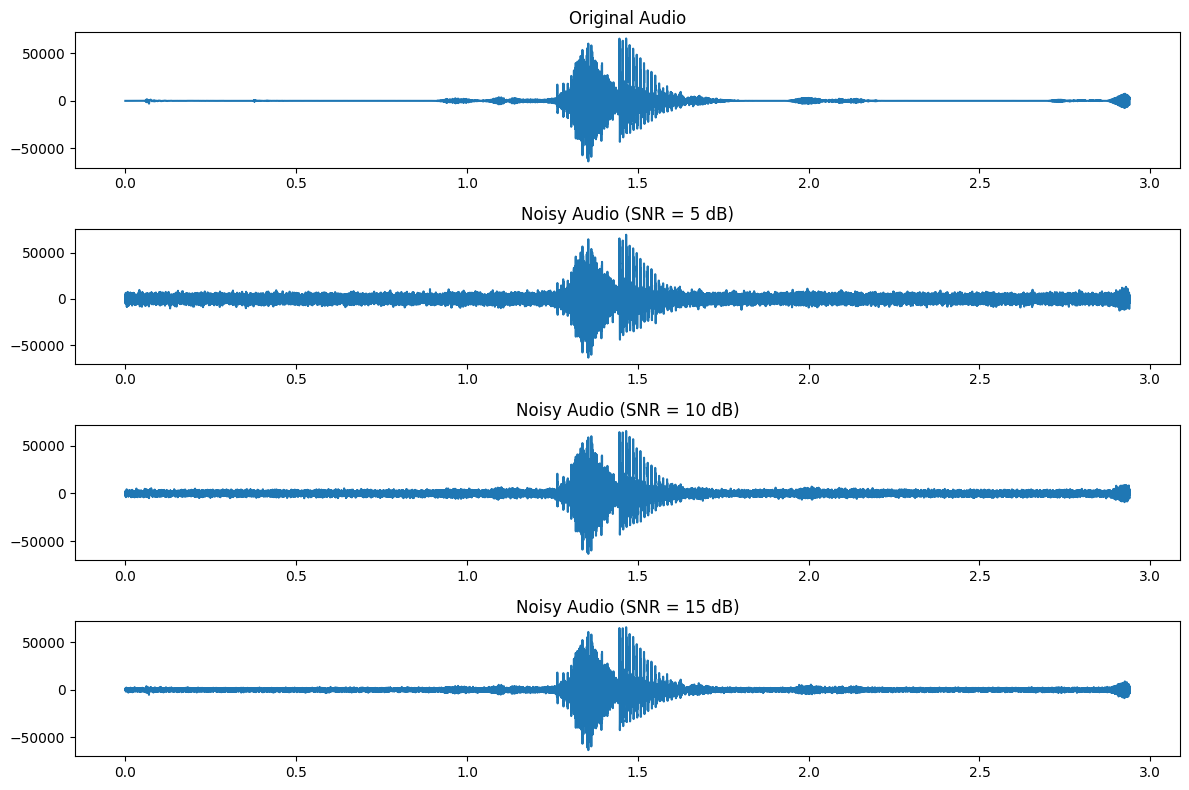

▶ Original


▶ Noisy 5dB


▶ Noisy 10dB


▶ Noisy 15dB


In [6]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import os
from IPython.display import Audio, display

os.makedirs("outputs", exist_ok=True)

# 노이즈 추가 함수(dB가 작 수록 노이즈가 많이 낀 것이다.)
#SNR은 신호 대 잡음 비이다.
#0dB는 신호와 노이즈가 같은 것이다.
def add_noise(signal, snr_db):
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), size=signal.shape)
    return signal + noise

# 파형 시각화
def plot_waveforms(original, noisy_list, sr, snr_list):
    time = np.arange(len(original)) / sr
    plt.figure(figsize=(12, 8))
    plt.subplot(len(noisy_list) + 1, 1, 1)
    plt.plot(time, original)
    plt.title("Original Audio")
    for i, (noisy, snr) in enumerate(zip(noisy_list, snr_list)):
        plt.subplot(len(noisy_list) + 1, 1, i + 2)
        plt.plot(time, noisy)
        plt.title(f"Noisy Audio (SNR = {snr} dB)")
    plt.tight_layout()
    plt.show()

# 오디오 재생 함수
def play_audio_files(file_paths, labels):
    for path, label in zip(file_paths, labels):
        print(f"▶ {label}")
        display(Audio(path))

# 안전한 int16 변환
def to_int16(signal):
    signal = signal / np.max(np.abs(signal))  # 클리핑 방지
    return (signal * 32767).astype(np.int16)

# 1. 오디오 로드
sr, audio = wav.read("converted.wav")

# 채널이 2개인 경우 → mono로 평균 처리
if audio.ndim == 2:
    audio = audio.mean(axis=1)

# 정규화
if audio.dtype != np.float32:
    audio = audio.astype(np.float32) / 32768.0

# 2. 노이즈 추가 및 저장
snr_list = [5, 10, 15]
noisy_signals = []
noisy_file_paths = []

for snr in snr_list:
    noisy = add_noise(audio, snr)
    noisy_signals.append(noisy)
    out_path = f"outputs/noisy_{snr}dB.wav"
    noisy_file_paths.append(out_path)
    wav.write(out_path, sr, to_int16(noisy))

# 3. 원본 저장
original_path = "outputs/original.wav"
wav.write(original_path, sr, to_int16(audio))

# 4. 파형 출력
plot_waveforms(audio, noisy_signals, sr, snr_list)

# 5. 재생
file_paths = [original_path] + noisy_file_paths
labels = ["Original"] + [f"Noisy {snr}dB" for snr in snr_list]
play_audio_files(file_paths, labels)

ZCR을 이용한 유성음/무성음 구분

/tmp/ipython-input-11-2467773880.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)


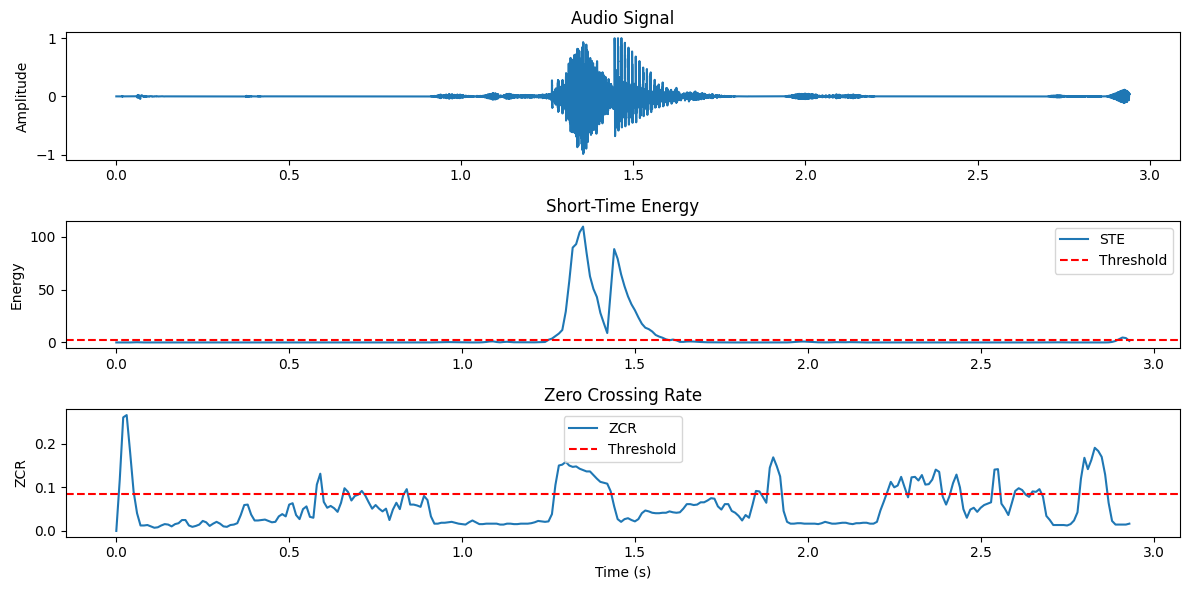

Voiced/Unvoiced 판별 결과 (처음 10프레임):
Frame 1: unvoiced
Frame 2: unvoiced
Frame 3: unvoiced
Frame 4: unvoiced
Frame 5: unvoiced
Frame 6: unvoiced
Frame 7: unvoiced
Frame 8: unvoiced
Frame 9: unvoiced
Frame 10: unvoiced
Frame 11: unvoiced
Frame 12: unvoiced
Frame 13: unvoiced
Frame 14: unvoiced
Frame 15: unvoiced
Frame 16: unvoiced
Frame 17: unvoiced
Frame 18: unvoiced
Frame 19: unvoiced
Frame 20: unvoiced
Frame 21: unvoiced
Frame 22: unvoiced
Frame 23: unvoiced
Frame 24: unvoiced
Frame 25: unvoiced
Frame 26: unvoiced
Frame 27: unvoiced
Frame 28: unvoiced
Frame 29: unvoiced
Frame 30: unvoiced
Frame 31: unvoiced
Frame 32: unvoiced
Frame 33: unvoiced
Frame 34: unvoiced
Frame 35: unvoiced
Frame 36: unvoiced
Frame 37: unvoiced
Frame 38: unvoiced
Frame 39: unvoiced
Frame 40: unvoiced
Frame 41: unvoiced
Frame 42: unvoiced
Frame 43: unvoiced
Frame 44: unvoiced
Frame 45: unvoiced
Frame 46: unvoiced
Frame 47: unvoiced
Frame 48: unvoiced
Frame 49: unvoiced
Frame 50: unvoiced
Frame 51: unvoiced
Frame 

In [11]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# 1. 오디오 파일 로드
audio_path = 'recorded.wav'
y, sr = librosa.load(audio_path, sr=None)

# 2. 프레임 길이 및 홉 길이 설정 (20ms, 10ms)
frame_length = int(0.02 * sr)  # 20ms
hop_length = int(0.01 * sr)    # 10ms

# 3. Short-Time Energy 계산
energy = np.array([
    np.sum(np.abs(y[i:i + frame_length] ** 2))
    for i in range(0, len(y), hop_length)
])

# 4. Zero Crossing Rate 계산
zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)[0]

# 5. 길이 맞추기 (오류 방지)
min_len = min(len(energy), len(zcr))
energy = energy[:min_len]
zcr = zcr[:min_len]

# 6. 시간 축 계산
time_axis = np.arange(min_len) * (hop_length / sr)

# 7. 임계값 설정
energy_threshold = np.mean(energy) * 0.5
zcr_threshold = np.mean(zcr) * 1.5

# 8. 유성음 / 무성음 판별
voiced_unvoiced = []
for e, z in zip(energy, zcr):
    if e > energy_threshold and z < zcr_threshold:
        voiced_unvoiced.append('voiced')
    else:
        voiced_unvoiced.append('unvoiced')

# 9. 시각화
plt.figure(figsize=(12, 6))

# 전체 오디오 파형
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, len(y) / sr, len(y)), y)
plt.title('Audio Signal')
plt.ylabel('Amplitude')

# Short-Time Energy
plt.subplot(3, 1, 2)
plt.plot(time_axis, energy, label='STE')
plt.axhline(y=energy_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Short-Time Energy')
plt.ylabel('Energy')
plt.legend()

# Zero Crossing Rate
plt.subplot(3, 1, 3)
plt.plot(time_axis, zcr, label='ZCR')
plt.axhline(y=zcr_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Zero Crossing Rate')
plt.xlabel('Time (s)')
plt.ylabel('ZCR')
plt.legend()

plt.tight_layout()
plt.show()

# 10. 판별 결과 일부 출력
print("Voiced/Unvoiced 판별 결과 (처음 10프레임):")
for i, vu in enumerate(voiced_unvoiced[:200]):
    print(f'Frame {i + 1}: {vu}')

음성구간검출

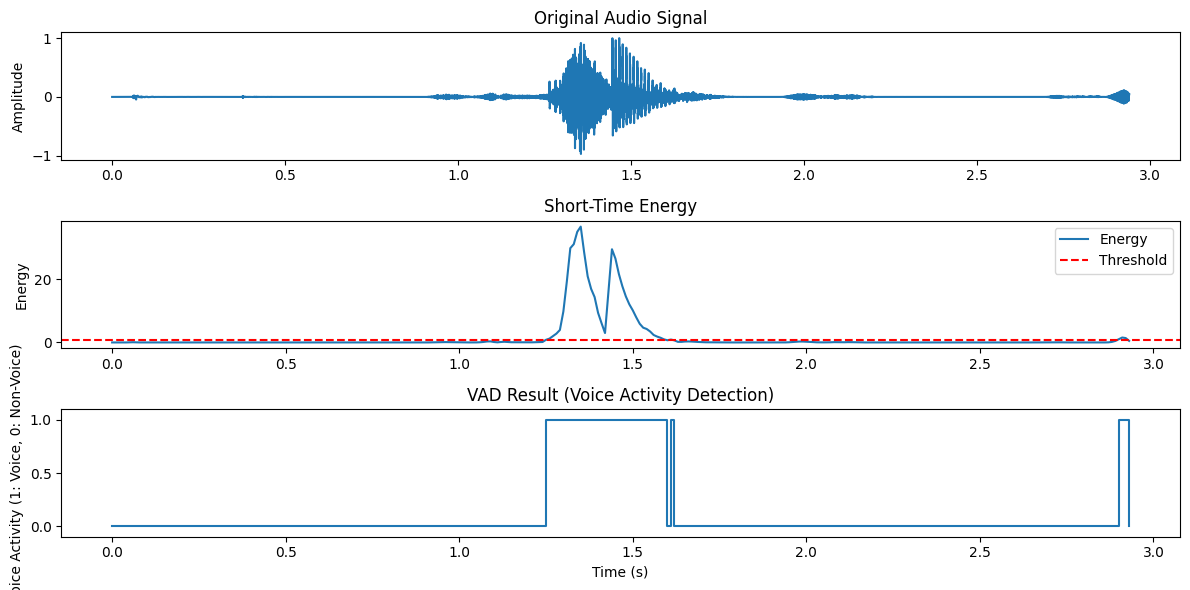

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# 오디오 파일 로드
audio_path = 'converted.wav'
y, sr = librosa.load(audio_path, sr=None)

# 파라미터 설정
frame_length = int(0.02 * sr)   # 20ms
hop_length = int(0.01 * sr)     # 10ms

# Short-Time Energy (STE) 계산
energy = np.array([
    np.sum(np.abs(y[i:i + frame_length]) ** 2)
    for i in range(0, len(y), hop_length)
])

# 에너지 임계값 설정 (평균 에너지의 0.5배로 설정)
energy_threshold = np.mean(energy) * 0.5

# VAD 수행 (음성 활동 판단)
vad_result = (energy > energy_threshold).astype(int)

# 시간축 생성
time_axis = np.arange(len(energy)) * (hop_length / sr)

# 결과 시각화
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
plt.title('Original Audio Signal')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(time_axis, energy, label='Energy')
plt.axhline(energy_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Short-Time Energy')
plt.ylabel('Energy')
plt.legend()

plt.subplot(3, 1, 3)
plt.step(time_axis, vad_result, where='post')
plt.title('VAD Result (Voice Activity Detection)')
plt.xlabel('Time (s)')
plt.ylabel('Voice Activity (1: Voice, 0: Non-Voice)')
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()